# Compare models

In this file, I will test and compare different model configurations using _BRMS_, which depends on _Stan_. The data is a subset of the BIBO project infants.

In [152]:
# load libraries
library(brms)
library(tidyverse)
library(broom)
library(tidybayes)
library(microbiome)
library(here)
library(glue)
source(here("R/bayesian_helper.R"))
# set global options 
options(mc.cores = 4)
theme_set(theme_bw())

In [4]:
df <- 
  read_csv(here("data/csv_gerben/data1.csv")) %>%
  select(-X1) %>%
  rename(sample_id = X1_1, age_weeks.s = age_weeks.c)
# df2 contains all genus  but not all processed meta variables
df2 <- 
  read_csv(here("data/csv_gerben/data2.csv")) %>%
  select(-X1) %>%
  rename(sample_id = X1_1)

# set correct data types for brm
df %>% summarise_all(class)
df <- df %>%
  mutate(
    age_weeks.s = as.numeric(age_weeks.s),
    feeding_type = as.factor(feeding_type),
    time = as.factor(time),
    childcarecenter = as.factor(childcarecenter)
)

Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Duplicated column names deduplicated: 'X1' => 'X1_1' [2]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  X1_1 = col_character(),
  subject = col_integer(),
  age_weeks = col_integer(),
  feeding_type = col_character(),
  time = col_integer(),
  childcarecenter = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Duplicated column names deduplicated: 'X1' => 'X1_1' [2]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  X1_1 = col_character(),
  Group = col_character(),
  groupcode = col_character(),
  subject = col_integer(),
  childcarecenter = col_integer(),
  breastfeeding = col_integer(),
  Tot_weeks_CC = col_integer(),
  ExactageCCmin2d = col_integer()
)
See spec(...) for full column specifications.


sample_id,Actinomycetaceae,Aerococcus,Akkermansia,Alcaligenes_faecalis_et_rel,Allistipes_et_rel,Anaerostipes_caccae_et_rel,Anaerotruncus_colihominis_et_rel,Anaerovorax_odorimutans_et_rel,Atopobium,⋯,Vibrio,Weissella_et_rel,Xanthomonadaceae,Yersinia_et_rel,subject,age_weeks,feeding_type,time,childcarecenter,age_weeks.s
character,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,⋯,numeric,numeric,numeric,numeric,integer,integer,character,integer,character,numeric


## Gaussian - Enterococcus

Because in the analysis we did for a paper using different frequentist methods the result was that there was a difference in this genus over time between childcare groups, I test how I would interpret this using ML linear regression. Before I fit ML regression, I fit unpooled and completely pooled models to later compare the models.

In [3]:
g.pooled <-
  brm(
    family = gaussian(),
    Enterococcus ~ 1,
    prior = set_prior("normal(0, 5)", class = "Intercept"),
    data = df, chains = 4, iter = 3000, warmup = 1000, 
    file = here("models/gaussian/Enterococcus_pooled")
)

In [5]:
g.pooled <-
  brm(
    family = gaussian(),
    Enterococcus ~ 1 + feeding_type + (1|subject),
    data = df,
)
summary(g.pooled)

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Enterococcus ~ 1 + feeding_type 
   Data: df (Number of observations: 174) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
               Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept          3.12      0.08     2.97     3.27       3910 1.00
feeding_typeIF     0.44      0.18     0.10     0.79       4000 1.00
feeding_typeMF     0.32      0.11     0.10     0.54       4000 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.69      0.04     0.62     0.77       4000 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

In [13]:
df$feeding_type

[1] BF MF BF BF BF BF MF MF MF MF MF MF MF MF IF IF IF IF BF BF BF BF MF MF MF
 [26] MF MF MF BF BF BF BF BF BF BF BF BF BF BF MF MF MF MF IF IF BF BF BF BF BF
 [51] BF MF IF IF BF BF MF MF MF MF BF BF BF MF MF MF BF BF IF IF MF MF BF BF BF
 [76] BF BF BF BF BF MF MF IF IF IF IF BF MF IF IF BF MF BF MF MF MF BF BF BF BF
[101] BF BF BF BF MF MF BF BF IF IF BF BF BF BF MF MF MF MF MF MF MF MF BF MF MF
[126] BF MF BF MF MF MF BF BF MF MF MF MF BF BF BF BF BF BF BF BF MF MF MF MF BF
[151] BF MF MF MF MF MF MF BF BF MF MF MF BF BF BF MF MF BF BF MF MF BF BF BF
Levels: BF IF MF

In [4]:
g.unpooled <- 
  brm(
    family = gaussian(),
    Enterococcus ~ 0 + factor(subject),
    prior = c(
      set_prior("cauchy(0, 1)", class = "sigma"),
      set_prior("normal(0, 5)", class = "b")
    ), data = df, chains = 4, iter = 3000, warmup = 1000, control = list(max_treedepth = 15),
      file = here("models/gaussian/Enterococcus_unpooled")
)

In the following I fit for one genus at a time several models and save the models in files. Since individual models need diagnostics and likely fine tuning.

In [5]:
# define path where model should be stored 
file <- here("models")
# add all genus like to the list
my_genus <- list("Enterococcus")
# initialize list to store models (g = gaussian)
g_models <- list()
# fit models
for (genus in my_genus) {
  # ----  random intercept only
  form <- glue("{genus} ~ 1 + (1|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m1")
  m1 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      prior = c(
        set_prior("normal(0, 5)", class = "Intercept"),
        set_prior("cauchy(0, 1)", class = "sigma"),
        set_prior("cauchy(0, 2)", class = "sd")),
      chains = 4, iter = 3000, warmup = 1000,
      control = list(max_treedepth = 15), file = model_file
    )
  
  # ---- add childcare
  form <- glue("{genus} ~ 1 + childcarecenter + (1|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m2")
  m2 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      prior = c(
        set_prior("normal(0, 5)", class = "Intercept"),
        set_prior("cauchy(0, 1)", class = "sigma"),
        set_prior("cauchy(0, 2)", class = "sd"), 
        set_prior("normal(0, 5)", class = "b")),
      chains = 4, iter = 3000, warmup = 1000,
      control = list(max_treedepth = 15), file = model_file
  )
  # ---- add time
  form <- glue("{genus} ~ 1 + childcarecenter*time + (1|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m3")
  m3 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      prior = c(
        set_prior("normal(0, 5)", class = "Intercept"),
        set_prior("cauchy(0, 1)", class = "sigma"),
        set_prior("cauchy(0, 2)", class = "sd"), 
        set_prior("normal(0, 5)", class = "b")),
      chains = 4, iter = 3000, warmup = 1000,
      control = list(adapt_delta = 0.9999, max_treedepth = 15),
      file = model_file
  )
  # ---- add time slope variation
  form <- glue("{genus} ~ 1 + childcarecenter*time + (1 + time|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m4")
  m4 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      chains = 4, iter = 3000, warmup = 1000,
      control = list(adapt_delta = 0.9999, max_treedepth = 15),
      file = model_file
  )
  # ---- add age_weeks.s
  form <- glue("{genus} ~ 1 + childcarecenter*time + age_weeks.s + (1|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m5")
  m5 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      prior = c(
        set_prior("normal(0, 5)", class = "Intercept"),
        set_prior("cauchy(0, 1)", class = "sigma"),
        set_prior("cauchy(0, 2)", class = "sd"), 
        set_prior("normal(0, 5)", class = "b")),
      chains = 4, iter = 3000, warmup = 1000,
      control = list(adapt_delta = 0.9999, max_treedepth = 15),
      file = model_file
  )
  # ---- add age_weeks.s random variation
  form <- glue("{genus} ~ 1 + childcarecenter*time + age_weeks.s + (1 + age_weeks.s|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m6")
  m6 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      prior = c(
        set_prior("normal(0, 5)", clxass = "Intercept"),
        set_prior("cauchy(0, 1)", class = "sigma"),
        set_prior("cauchy(0, 2)", class = "sd"), 
        set_prior("normal(0, 5)", class = "b"), 
        set_prior("lkj(2)", class = "cor")),
      chains = 4, iter = 3000, warmup = 1000,
      control = list(adapt_delta = 0.9999, max_treedepth = 15),
      file = model_file
  )
  # ---- add variable intercept and slope per subject for both age and time
  form <- glue("{genus} ~ 1 + childcarecenter*time + age_weeks.s + (1 + age_weeks.s + time|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m7")
  m7 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      prior = c(
        set_prior("normal(0, 5)", class = "Intercept"),
        set_prior("cauchy(0, 1)", class = "sigma"),
        set_prior("cauchy(0, 2)", class = "sd"), 
        set_prior("normal(0, 5)", class = "b"), 
        set_prior("lkj(2)", class = "cor")),
      chains = 4, iter = 3000, warmup = 1000,
      control = list(adapt_delta = 0.9999, max_treedepth = 15),
      file = model_file
  )
  # ---- add feeding_type
  form <- glue("{genus} ~ 1 + childcarecenter*time*feeding_type + age_weeks.s + (1|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m8")
  m8 <- 
    brm(
      family = gaussian(), data = df,
      formula = form, 
      prior = c(
        set_prior("normal(0, 5)", class = "Intercept"),
        set_prior("cauchy(0, 1)", class = "sigma"),
        set_prior("cauchy(0, 2)", class = "sd"), 
        set_prior("normal(0, 5)", class = "b")),
      chains = 4, iter = 3000, warmup = 1000,
      control = list(adapt_delta = 0.9999, max_treedepth = 15),
      file = model_file
  )
  # ---- add variable slope and intercept again for age and time
  form <- glue("{genus} ~ 1 + childcarecenter*time*feeding_type + age_weeks.s + (1 + age_weeks.s + time|subject)")
  # give feedback in the process 
  cat("\nfitting model", form)
  # give individual model name for storage
  model_file <- glue("{file}/gaussian/{genus}_m9")
  m9 <- 
    brm(
      family = gaussian(), data = df,
      formula = form,
      chains = 4, iter = 5000, warmup = 1500,
      control = list(adapt_delta = 0.9999, max_treedepth = 15),
      file = model_file
)
  # store fitted models 
  g_models[[genus]] <- list(m1, m2, m3, m4, m5, m6, m7, m8, m9)
}



fitting model Enterococcus ~ 1 + (1|subject)
fitting model Enterococcus ~ 1 + childcarecenter + (1|subject)
fitting model Enterococcus ~ 1 + childcarecenter*time + (1|subject)
fitting model Enterococcus ~ 1 + childcarecenter*time + (1 + time|subject)
fitting model Enterococcus ~ 1 + childcarecenter*time + age_weeks.s + (1|subject)
fitting model Enterococcus ~ 1 + childcarecenter*time + age_weeks.s + (1 + age_weeks.s|subject)
fitting model Enterococcus ~ 1 + childcarecenter*time + age_weeks.s + (1 + age_weeks.s + time|subject)
fitting model Enterococcus ~ 1 + childcarecenter*time*feeding_type + age_weeks.s + (1|subject)
fitting model Enterococcus ~ 1 + childcarecenter*time*feeding_type + age_weeks.s + (1 + age_weeks.s + time|subject)

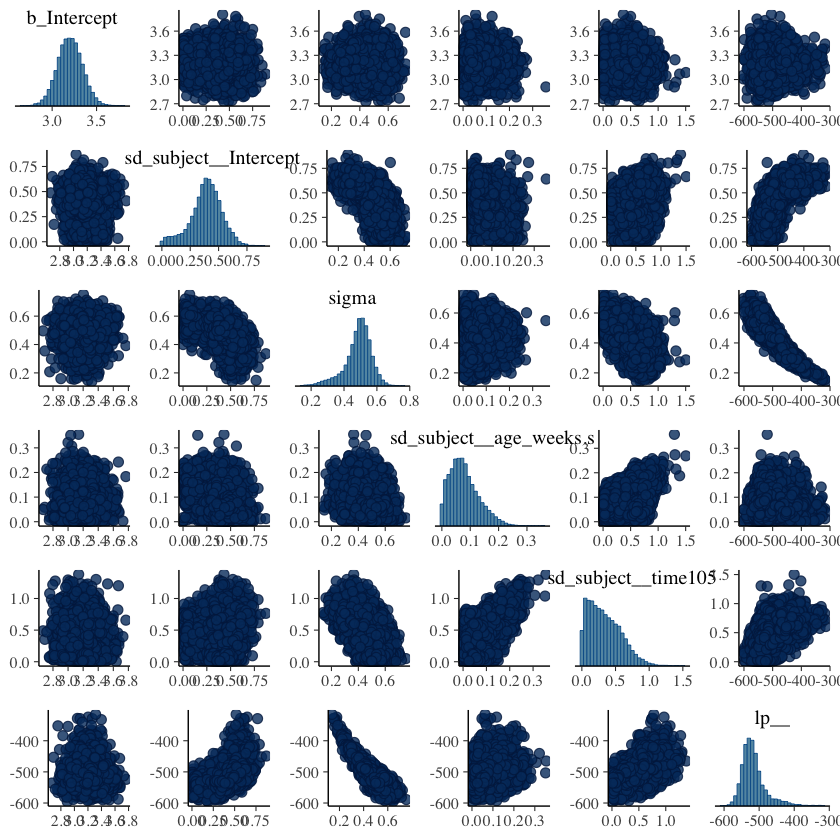

In [6]:
# here, I checked each model for warnings to learn which models I can trust.
# model 3 seems interesting to go on at first to better understand the interaction. The hypothesis was that
# infants in CC differ over time compared to no CC. The interaction here suggests that the two groups have opposite
# effects over time on average.
# Models with problems: 4, 7, 9. 4 and  9 did not converge...I tried then lkj4 for more conservative correlation. 
# after that stronger priors on b and more flexible prior on intercept. No success.
pairs(g_models$Enterococcus[[9]], pars = c("b_Intercept","sd_subject__Intercept", "sigma", "sd_subject__age_weeks.s", "sd_subject__time105", "lp__"))

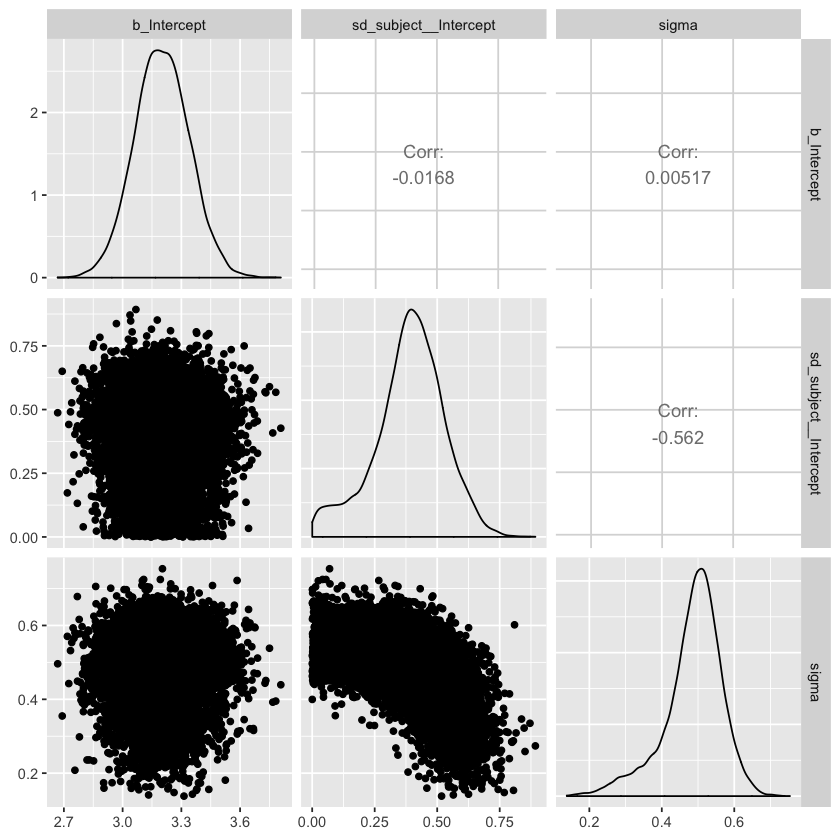

In [7]:
# let me copy this plot to make sure I am looking at what I think I am looking at
post <- g_models$Enterococcus[[9]] %>% as.tibble()
post %>% select(b_Intercept, sd_subject__Intercept,sigma) %>%
    GGally::ggpairs()

In [8]:
# assign model with divergences to div_fit
div_fit <- g_models$Enterococcus[[9]]

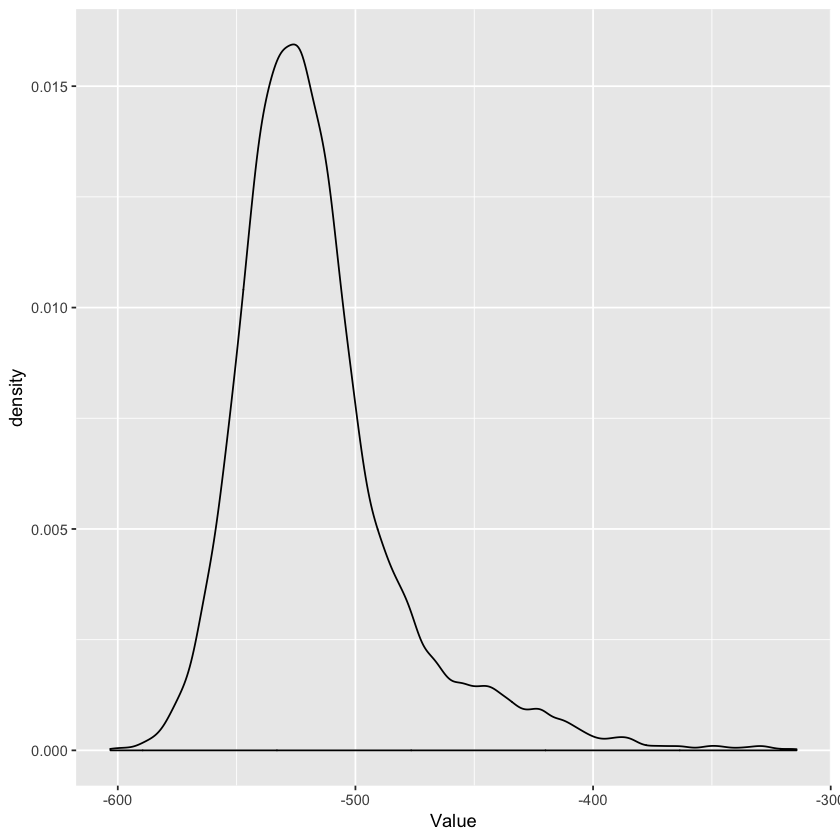

In [9]:
lp <- log_posterior(div_fit)
ggplot(lp, aes(Value)) +
    geom_density()

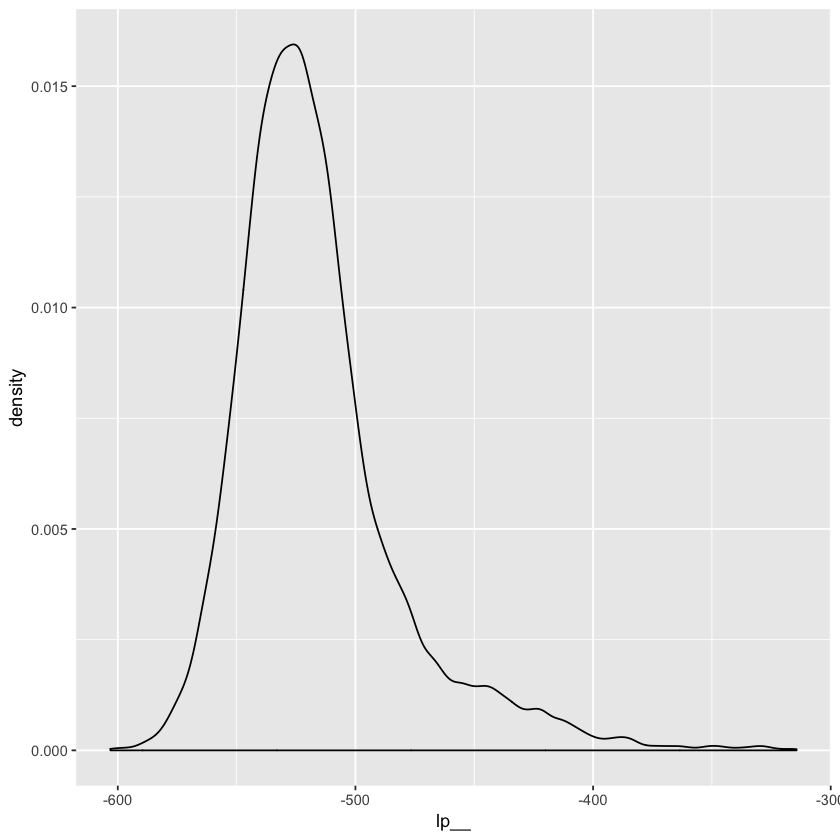

In [10]:
ggplot(post, aes(lp__)) +
    geom_density()

In [11]:
# extract diagnostic values
np <- nuts_params(div_fit)
#filter(np, Parameter == 'divergent__')
distinct(np, Parameter)
colnames(np)

Parameter
accept_stat__
stepsize__
treedepth__
n_leapfrog__
divergent__
energy__


[1] "Iteration" "Parameter" "Value"     "Chain"

In [12]:
g_models$Enterococcus[[9]]

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Enterococcus ~ 1 + childcarecenter * time * feeding_type + age_weeks.s + (1 + age_weeks.s + time | subject) 
   Data: df (Number of observations: 174) 
Samples: 4 chains, each with iter = 5000; warmup = 1500; thin = 1;
         total post-warmup samples = 14000

Group-Level Effects: 
~subject (Number of levels: 89) 
                           Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)                  0.39      0.14     0.06     0.64        581 1.01
sd(age_weeks.s)                0.08      0.05     0.00     0.20        686 1.01
sd(time105)                    0.34      0.24     0.01     0.87        311 1.01
cor(Intercept,age_weeks.s)    -0.27      0.42    -0.92     0.63       1181 1.00
cor(Intercept,time105)        -0.19      0.44    -0.84     0.78       1702 1.00
cor(age_weeks.s,time105)      -0.31      0.51    -0.96     0.78       1082 1.00

Population-Level Effects: 
                        

### Default priors in BRMS worked
I ran model 9 and 4 with the default priors of BRMS and at least model 9 showed no more warnings then. So what are the default priors?

From the [manual](https://rdrr.io/cran/brms/man/set_prior.html):

> The default prior for population-level effects (including monotonic and category specific effects) is an improper flat prior over the reals...

and about sigma

> These parameters are restricted to be non-negative and, by default, have a half student-t prior with 3 degrees of freedom and a scale parameter that depends on the standard deviation of the response after applying the link function. Minimally, the scale parameter is 10. This prior is used (a) to be only very weakly informative in order to influence results as few as possible, while (b) providing at least some regularization to considerably improve convergence and sampling efficiency.

Correlations have default: lkj(1), which assigns equal likely values for all possible correlations. I had set this to lkj(2).  Right now, I do not really grasp why exactly these priors produce no divergent observations whereas the half cauchy distribution and the priors on population parameters did. I will now test this out in more detail:



In [13]:
# ---- add variable slope and intercept again for age and time
form <- glue("{genus} ~ 1 + childcarecenter*time*feeding_type + age_weeks.s + (1 + age_weeks.s + time|subject)")
# give feedback in the process 
cat("\nfitting model", form)
# give individual model name for storage
model_file <- glue("{file}/gaussian/{genus}_m9")
m9 <- 
brm(
  family = gaussian(), data = df,
  formula = form,
  chains = 4, iter = 5000, warmup = 1500,
  control = list(adapt_delta = 0.9999, max_treedepth = 15)
)


fitting model Enterococcus ~ 1 + childcarecenter*time*feeding_type + age_weeks.s + (1 + age_weeks.s + time|subject)

Compiling the C++ model
Start sampling
Warning message:
“There were 135 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [14]:
nodiv <- g_models$Enterococcus[[9]]
print(stancode(nodiv))

// generated with brms 2.4.0
functions { 
} 
data { 
  int<lower=1> N;  // total number of observations 
  vector[N] Y;  // response variable 
  int<lower=1> K;  // number of population-level effects 
  matrix[N, K] X;  // population-level design matrix 
  // data for group-level effects of ID 1
  int<lower=1> J_1[N];
  int<lower=1> N_1;
  int<lower=1> M_1;
  vector[N] Z_1_1;
  vector[N] Z_1_2;
  vector[N] Z_1_3;
  int<lower=1> NC_1;
  int prior_only;  // should the likelihood be ignored? 
} 
transformed data { 
  int Kc = K - 1; 
  matrix[N, K - 1] Xc;  // centered version of X 
  vector[K - 1] means_X;  // column means of X before centering 
  for (i in 2:K) { 
    means_X[i - 1] = mean(X[, i]); 
    Xc[, i - 1] = X[, i] - means_X[i - 1]; 
  } 
} 
parameters { 
  vector[Kc] b;  // population-level effects 
  real temp_Intercept;  // temporary intercept 
  real<lower=0> sigma;  // residual SD 
  vector<lower=0>[M_1] sd_1;  // group-level standard deviations
  matrix[M_1, N_1] z_1;  //

# Bilophila
Since Gerben mentionted it in the paper I take a look at this one and try out distributional model:

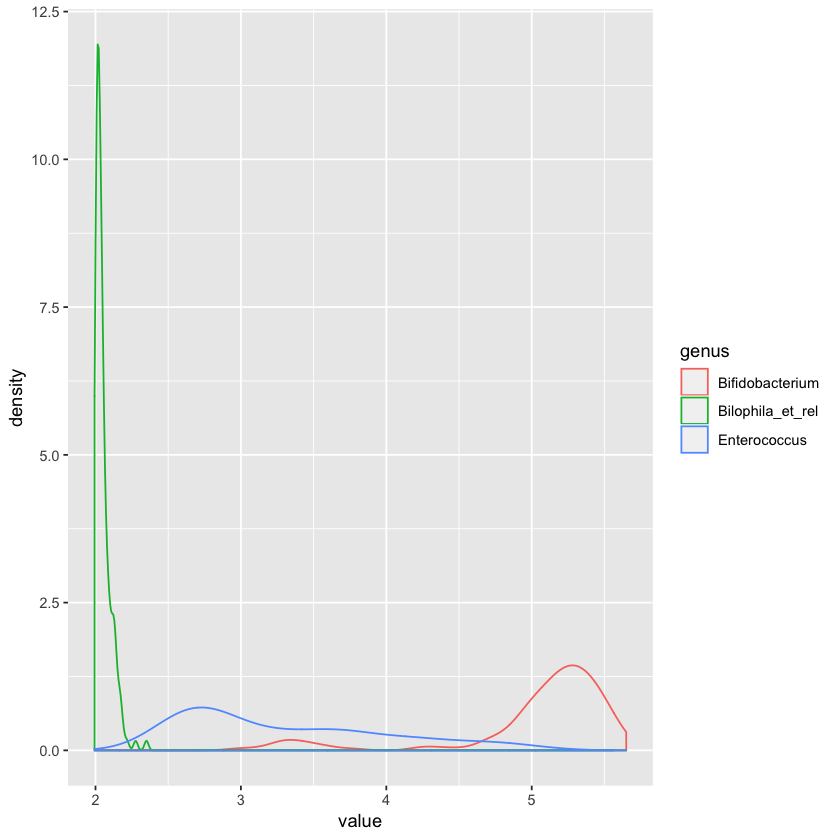

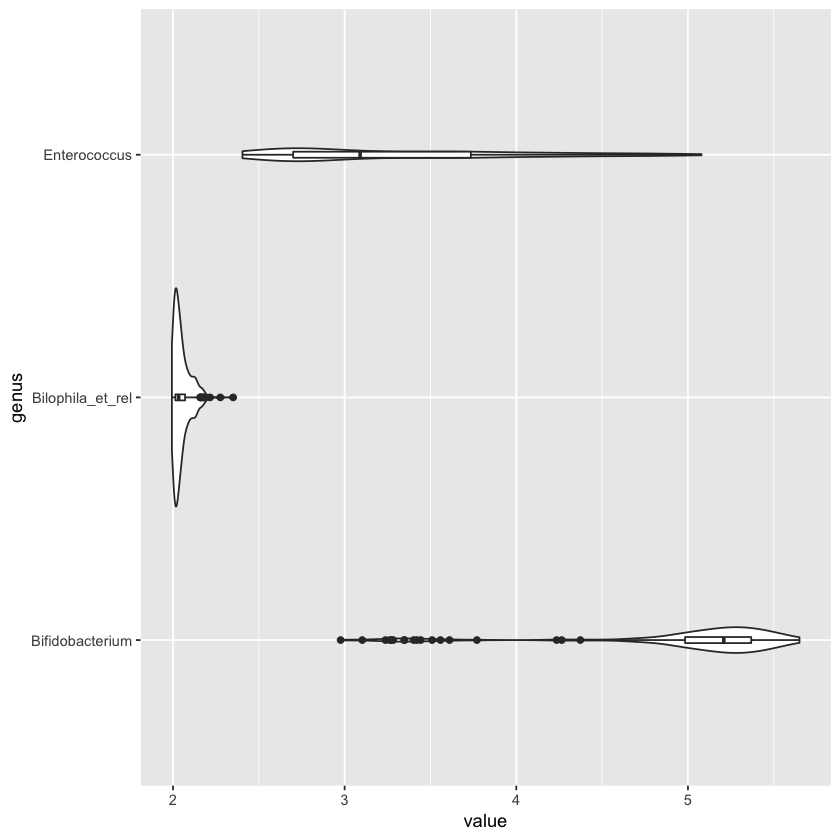

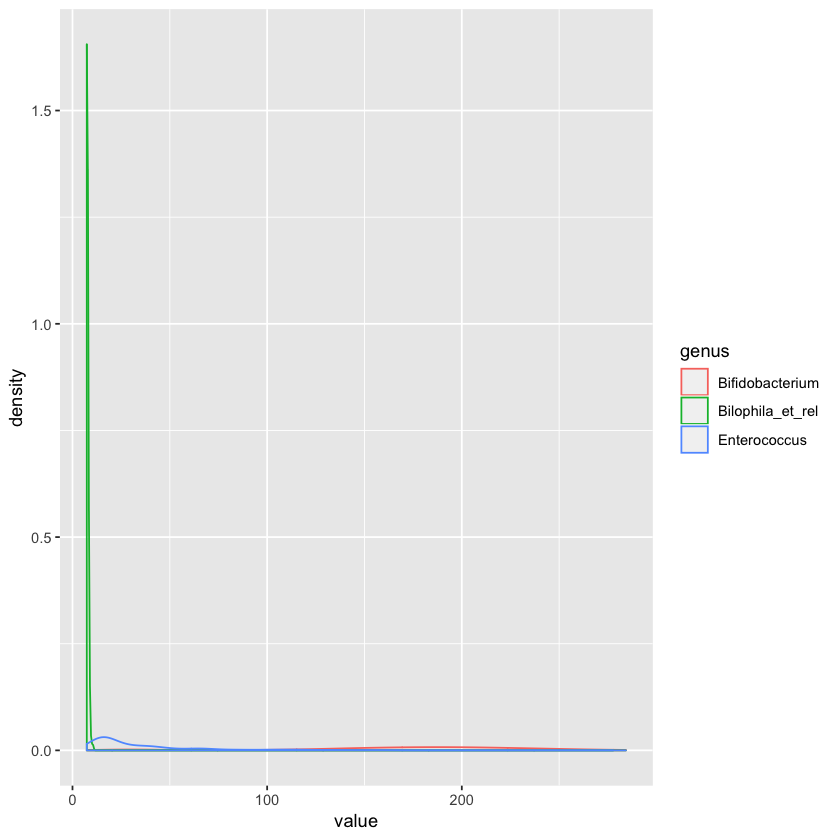

In [15]:
df %>% select(Bifidobacterium, Bilophila_et_rel, Enterococcus) %>%
    gather(genus, value) %>%
    ggplot(aes(value, color = genus)) +
    geom_density()
df %>% select(Bifidobacterium, Bilophila_et_rel, Enterococcus) %>%
    gather(genus, value) %>%
    ggplot(aes(genus, value)) +
    geom_violin() +
    geom_boxplot(width = 0.025) +
    coord_flip()
df %>% select(Bifidobacterium, Bilophila_et_rel, Enterococcus) %>%
    mutate_all(exp) %>%
    gather(genus, value) %>%
    ggplot(aes(value, color = genus)) +
    geom_density()

## Distributional models   
Given heterogeneity of residual variance, it seems reasonable to fit distributional models. But not only from a statistical point of view does this make sense to me: It might well be that any of those predictors (_feeding mode_, _time_ and _time:cc_) impact only some imfants so that the variance is different in the subgroups. I will start simple by first including one variable in a model. The basic model outlook then is:

**likelihood function**  
$y_i \sim Normal(\mu_i, \sigma_i)$  
$\mu_i = \alpha_{\mu i} + \alpha_{\mu i -subject} + X_i\beta_{\mu}$  
$log(\sigma_i) = \alpha_{\sigma i} + \alpha_{\sigma i -subject} +X_i\beta_{\sigma}$  
**Prior probabilities**  
$\alpha_{\mu} \sim Normal(0, 5)$  
$\alpha_{\sigma} \sim Normal(0, 1)$  
$\alpha_{\mu -subject} \sim Normal(0, \sigma_{\mu -subject})$  
$\alpha_{\sigma -subject} \sim Normal(0, \sigma_{\sigma -subject})$  
$[\sigma_{\mu -subject}, \sigma_{\sigma -subject}] \sim cauchy(0, 1)$   
$[\beta_{\mu}, \beta_{\mu}] \sim Normal(0, 1)$  


Below, I will take notes so that I have some guidance about what I tried. The goal is to first get a feel how I best can fit these models. 

Edit: It was difficult even with one variable (_time_) to get a trustable model. It was possible using the student t family. Therefore, I go on only with this at first. Then model for time for example is:

**likelihood function**  
$y_i \sim T(\nu, \mu_i, \sigma_i)$  
$\mu_i = \alpha_{\mu i} + \alpha_{\mu i -subject} + time_i\beta_{1\mu} + cc_i\beta_{2\mu} + time_i\times cc_i\beta_{3\mu}$  
$log(\sigma_i) = \alpha_{\sigma i} + \alpha_{\sigma i -subject} +time_i\beta_{\sigma}$  
**Prior probabilities**  
$\alpha_{\mu} \sim Normal(0, 5)$  
$\alpha_{\sigma} \sim Normal(0, 1)$  
$\alpha_{\mu -subject} \sim Normal(0, \sigma_{\mu -subject})$  
$\alpha_{\sigma -subject} \sim Normal(0, \sigma_{\sigma -subject})$  
$[\sigma_{\mu -subject}, \sigma_{\sigma -subject}] \sim cauchy(0, 1)$   
$[\beta_{\mu}, \beta_{\mu}] \sim Normal(0, 1)$  
$\nu \sim Gamma(2, 0.1)$






## Notes about convergence

In only write about _not converged_ or _divergent transitions_ after also trying the control option. Looking at the residual distributions after fitting gaussian models using LME4 a few months back, I think that the skew_normal should be suited to estimate some of those but I found that I have not yet the grasp how to tune the models to avoid divergent transitions but let's try...

### Gaussian Distributional 

#### Time 
1. 2 divergent transitions with default model
2. 3 divergent transitions with these priors:
```
set_prior("normal(0, 1)", class = "b"),
set_prior("exponential(6)", class = "sd"),
set_prior("normal(0, 5)", class = "Intercept"), 
set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
set_prior("exponential(6)", class = "sd", dpar = "sigma"),
set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
```

#### Full model
Full here solely means that this is the maximum complexity I found sensible.  
1. The model denoted as `form <- bf(Bilophila_et_rel ~ 1 + childcarecenter*time + age_weeks.s + (1|subject), sigma ~ 1 + childcarecenter*time + age_weeks.s + (1|subject))` did not converge for any of the three families with the default priors.  

### Student T

#### Time 
1. converged with this setup:
```
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
prior = c(
    set_prior("normal(0, 1)", class = "b"),
    set_prior("exponential(6)", class = "sd"),
    set_prior("normal(0, 5)", class = "Intercept"), 
    set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
    set_prior("exponential(6)", class = "sd", dpar = "sigma"),
    set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
)
```

### Skew normal Distributional 


#### Time 

1. 8 divergent transitions for default model.


### Questions 

1. Can I interpret models with this warning: `“There were 2 chains where the estimated Bayesian Fraction of Missing Information was low..."`?

## Predictor Time

In [16]:
# % outlier
df %>% 
    mutate(Bilo.s = scale(Bilophila_et_rel)[, 1]) %>% 
    summarise(outliers = mean(abs(Bilo.s) > 3))

outliers
0.01724138


### Distributional Time Gaussian (dg_time)

In [17]:
# specify files and model options
genus <-"Bilophila_et_rel"
time <- bf(Bilophila_et_rel ~ 1 + time + (1|subject), sigma ~ 1 + time + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/gaussian/{genus}_time")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

/Users/henrikeckermann/workspace/research_master/major_research_project/ressources/stan_models/models/distributional/gaussian/Bilophila_et_rel_time


In [18]:
dg_time <- 
brm(
    family = gaussian(), data = df, formula = time, control = control,
    file = model_file, chains = 4, iter = 3000, warmup = 1000, prior = c(
            set_prior("normal(0, 1)", class = "b"),
            set_prior("exponential(6)", class = "sd"),
            set_prior("normal(0, 5)", class = "Intercept"), 
            set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
            set_prior("exponential(6)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
    )
    
)

In [19]:
summary(dg_time)

Warning message:
“There were 3 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: Bilophila_et_rel ~ 1 + time + (1 | subject) 
         sigma ~ 1 + time + (1 | subject)
   Data: df (Number of observations: 174) 
Samples: 4 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup samples = 8000

Group-Level Effects: 
~subject (Number of levels: 89) 
                    Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)           0.02      0.01     0.01     0.03        587 1.01
sd(sigma_Intercept)     0.83      0.14     0.55     1.12       1193 1.00

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept           2.04      0.01     2.03     2.05       1128 1.00
sigma_Intercept    -3.53      0.16    -3.85    -3.22       1766 1.00
time105            -0.01      0.00    -0.02    -0.01       5484 1.00
sigma_time105      -0.28      0.19    -0.68     0.08       2704 1.00

Samples were drawn using sampling(NUTS). For ea

### Distributional base (dt_base)

In [20]:
# specify files and model options
genus <-"Bilophila_et_rel"
base <- bf(Bilophila_et_rel ~ 1 + (1|subject), sigma ~ 1 + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/t/{genus}_base_nc_default")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

/Users/henrikeckermann/workspace/research_master/major_research_project/ressources/stan_models/models/distributional/t/Bilophila_et_rel_base_nc_default


In [21]:
dt_base <- 
    brm(
        family = student(), data = df, formula = base, 
        chains = 4, iter = 3000, warmup = 1000,
        file = model_file
)

In [22]:
# calculate loo
#t_base_loo <- loo(dt_base)
# calculate kfold (there were 58 k values >...)
#t_base_cv10 <- kfold(dt_base)
t_base_cv10

ERROR: Error in eval(expr, envir, enclos): object 't_base_cv10' not found


### Distributional Time Student t (dt_time)

In [79]:
# specify files and model options
genus <-"Bilophila_et_rel"
time <- bf(Bilophila_et_rel ~ 1 + time + (1|subject), sigma ~ 1 + time + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/cc_and_feeding/distributional_t/{genus}_time")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

/Users/henrikeckermann/workspace/research_master/major_research_project/orl_major_project/models/cc_and_feeding/distributional_t/Bilophila_et_rel_time


In [80]:
dt_time <- 
    brm(
        family = student(), data = df, formula = time, 
        chains = 4, iter = 3000, warmup = 1000,
        file = model_file, control = control, prior = c(
            set_prior("normal(0, 1)", class = "b"),
            set_prior("exponential(6)", class = "sd"),
            set_prior("normal(0, 5)", class = "Intercept"), 
            set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
            set_prior("exponential(6)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
        )
)

Compiling the C++ model
Start sampling
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [81]:
summary(dt_time)

 Family: student 
  Links: mu = identity; sigma = log; nu = identity 
Formula: Bilophila_et_rel ~ 1 + time + (1 | subject) 
         sigma ~ 1 + time + (1 | subject)
   Data: df (Number of observations: 174) 
Samples: 4 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup samples = 8000

Group-Level Effects: 
~subject (Number of levels: 89) 
                    Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)           0.02      0.01     0.01     0.04        504 1.01
sd(sigma_Intercept)     0.81      0.15     0.52     1.11       1356 1.00

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept           2.04      0.01     2.03     2.05       1090 1.01
sigma_Intercept    -3.58      0.17    -3.93    -3.26       1922 1.00
time105            -0.01      0.00    -0.02    -0.01       5752 1.00
sigma_time105      -0.29      0.20    -0.70     0.09       2209 1.00

Family Specific Parameters: 
   E

In [ ]:
post <- dt_time %>% as.tibble()
dim(post)

### Distributional Time Skew Normal (dsn_time)

In [56]:
# specify files and model options
genus <-"Bilophila_et_rel"
time <- bf(Bilophila_et_rel ~ 1 + time + (1|subject), sigma ~ 1 + time + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/cc_and_feeding/distributional_skew_normal/{genus}_time")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

/Users/henrikeckermann/workspace/research_master/major_research_project/orl_major_project/models/cc_and_feeding/distributional_skew_normal/Bilophila_et_rel_time


In [57]:
dsn_time <- 
    brm(
        family = skew_normal(), data = df, formula = time,
        chains = 4, iter = 3000, warmup = 1000,
        file = model_file, control = control, prior = c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(10)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(10)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
        )
)

Compiling the C++ model
Start sampling


In [ ]:
get_prior(family = student(), data = df, formula = time_cc)
rt(1e4, df = 3, mean = 0, scale = 10)

In [59]:
summary(dsn_time)

 Family: skew_normal 
  Links: mu = identity; sigma = log; alpha = identity 
Formula: Bilophila_et_rel ~ 1 + time + (1 | subject) 
         sigma ~ 1 + time + (1 | subject)
   Data: df (Number of observations: 174) 
Samples: 4 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup samples = 8000

Group-Level Effects: 
~subject (Number of levels: 89) 
                    Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)           0.00      0.00     0.00     0.01        941 1.00
sd(sigma_Intercept)     0.15      0.09     0.01     0.34       1188 1.00

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept           2.06      0.01     2.05     2.07       2732 1.00
sigma_Intercept    -3.05      0.11    -3.26    -2.85       1664 1.00
time105            -0.02      0.01    -0.03    -0.01       8000 1.00
sigma_time105      -0.24      0.12    -0.47    -0.01       8000 1.00

Family Specific Parameters

### Interpretation for the converged model

Bevor trying out other more complex models, I try to interpret the simplest model

Using 10 posterior samples for ppc type 'dens_overlay' by default.


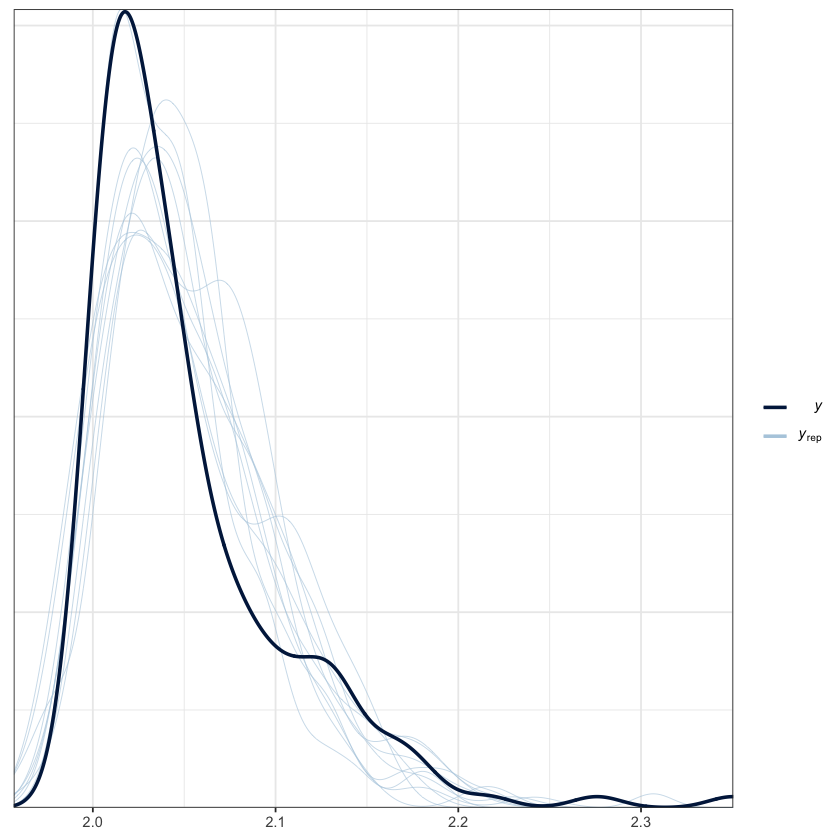

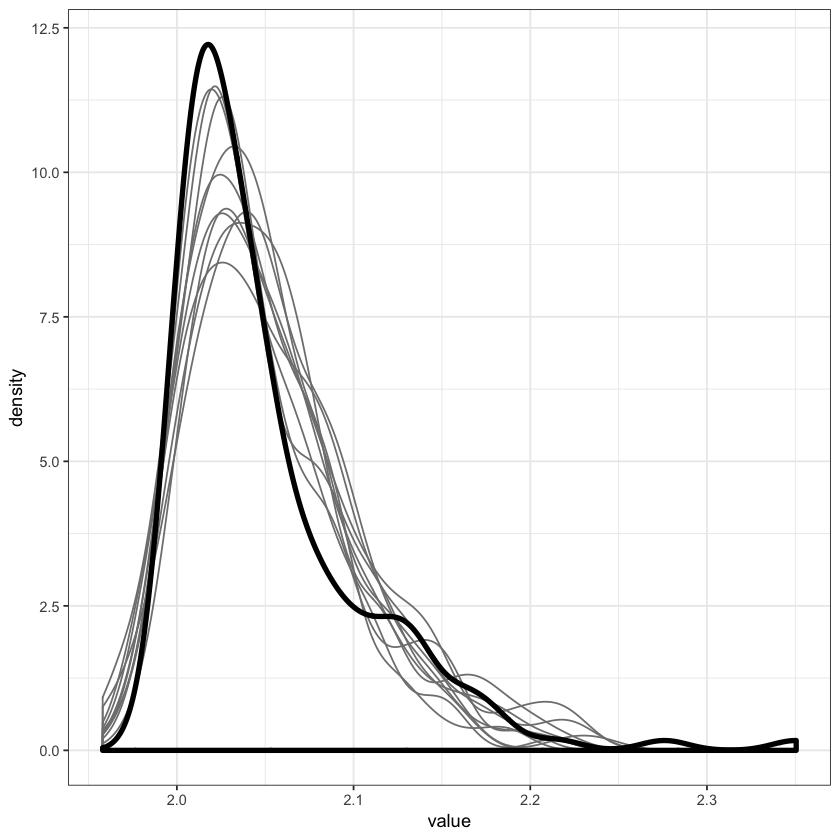

Using 10 posterior samples for ppc type 'dens_overlay' by default.


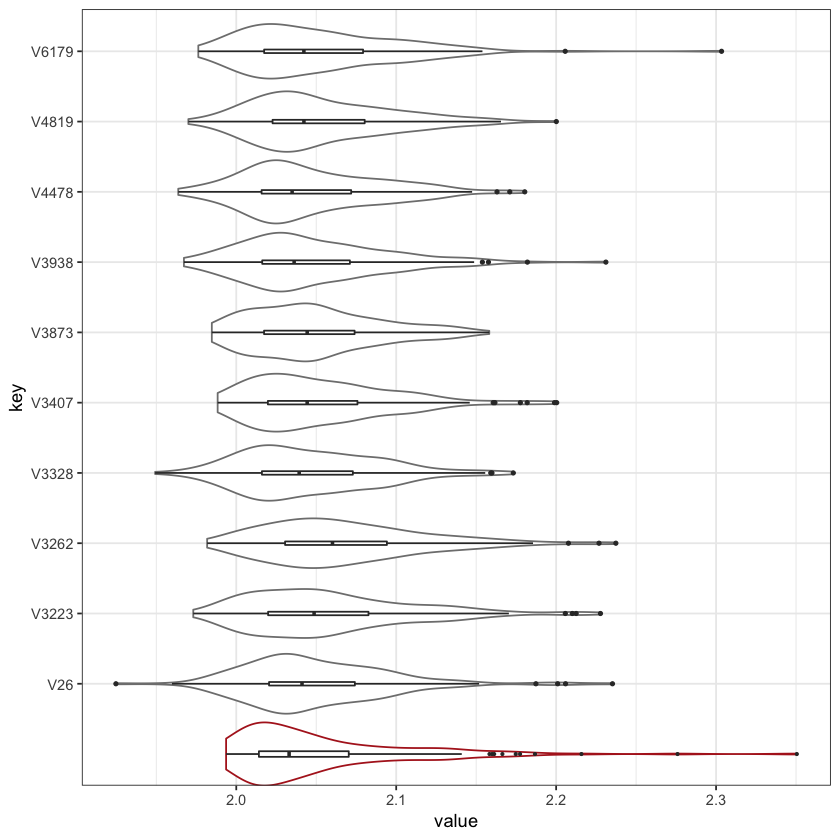

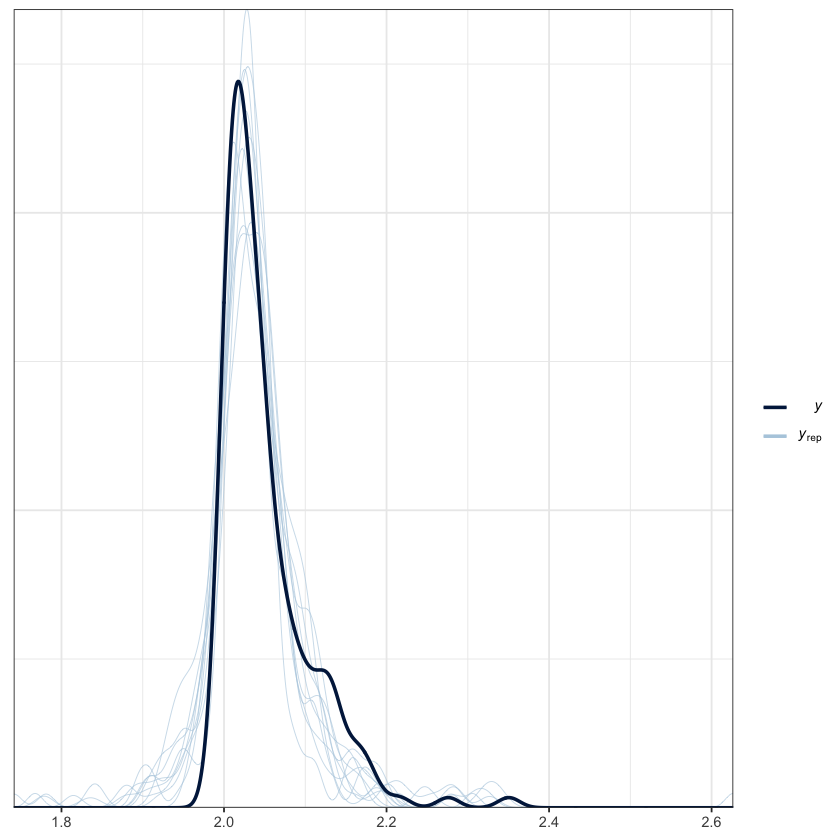

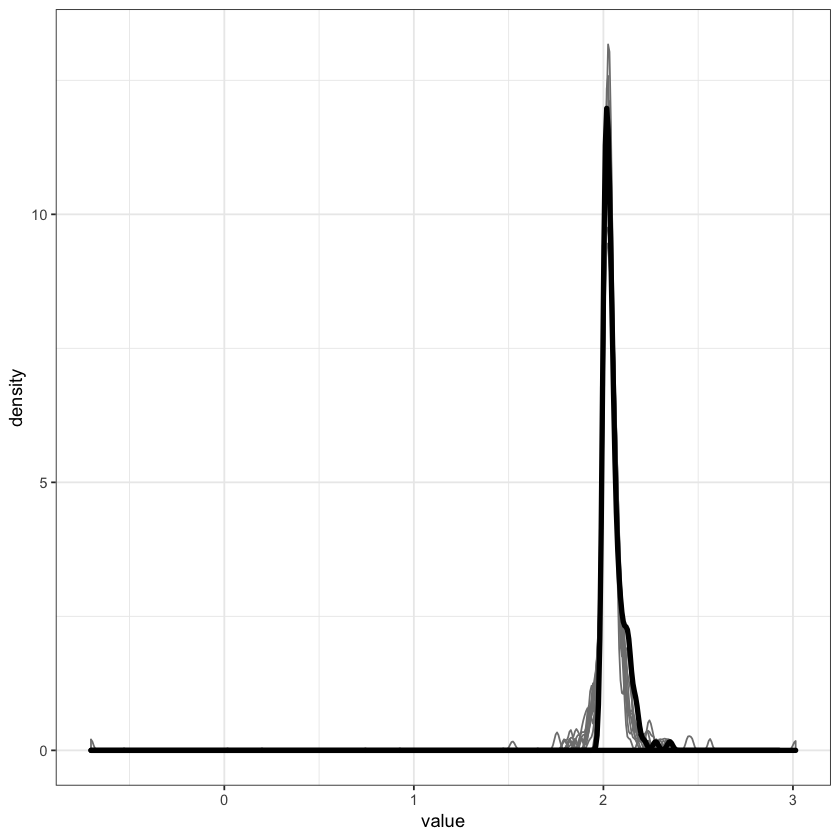

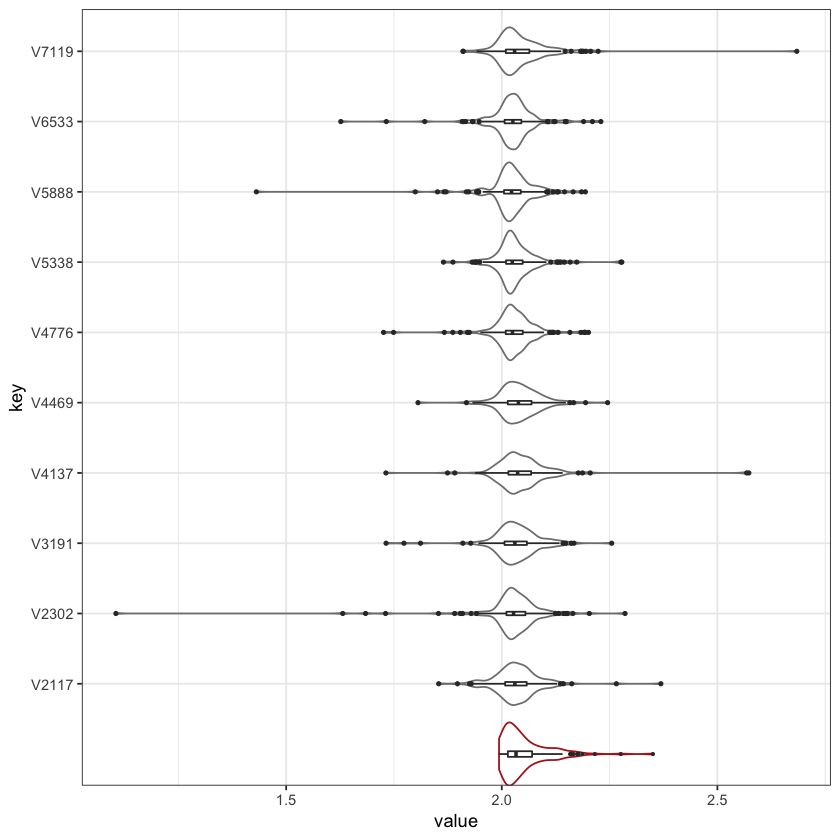

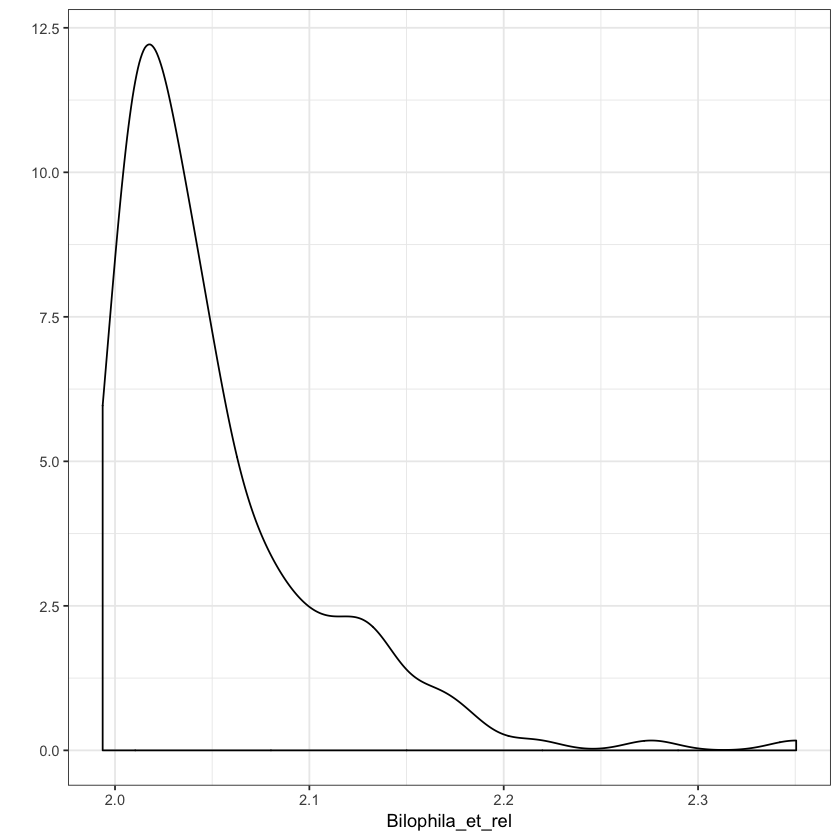

In [162]:
source(here("R/bayesian_helper.R"))
# calculate loo
# t_time_loo <- loo(dt_time)
# calculate kfold (there were 76 k values >...)
#t_time_cv10 <- kfold(dt_time)
# posterior predictive check
pp_check(dsn_time)
# try out what my own function produces 
pp_plot(dsn_time, sample_number = 10, y_name = genus)
pp_plot_v(dsn_time, sample_number = 10, y_name = genus)
# posterior predictive check
pp_check(dt_time) 
# try out what my own function produces 
pp_plot(dt_time, sample_number = 10, y_name = genus)
pp_plot_v(dt_time, sample_number = 10, y_name = genus)
qplot(data = df, Bilophila_et_rel, geom = "density") 

No summary function supplied, defaulting to `mean_se()


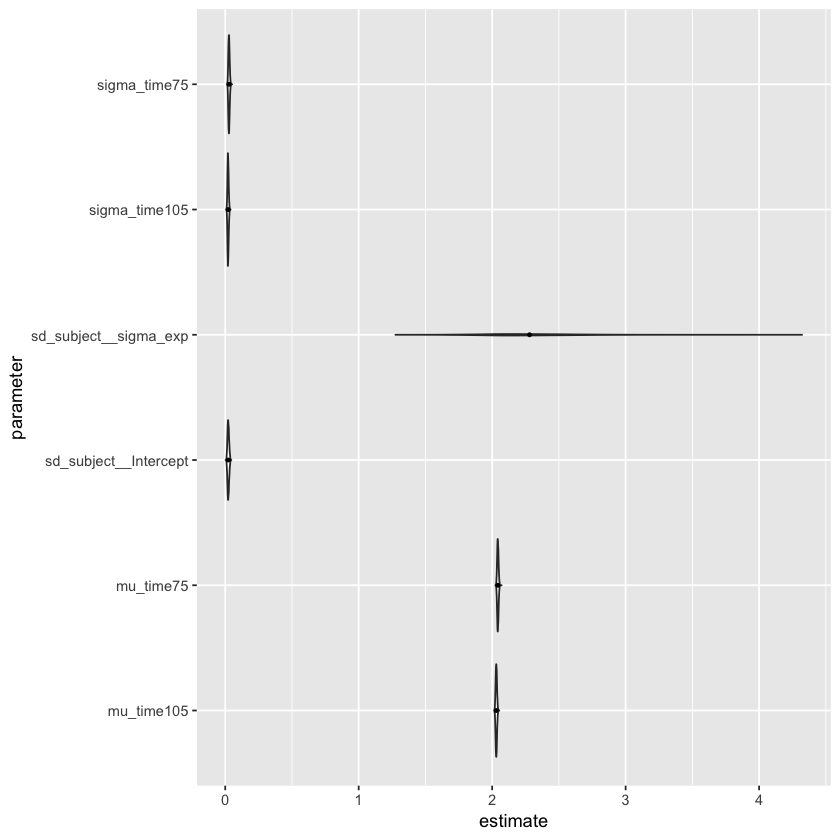

In [117]:
# the summary shows variation in the intercept between individuals but no 
# certain effect of time. But how meaningful would these effect be anyway?
dt_time %>% as.tibble() %>%
    mutate(
        mu_time75 = b_Intercept,
        mu_time105 = b_Intercept + b_time105,
        sigma_time75 = exp(b_sigma_Intercept),
        sigma_time105 = exp((b_sigma_Intercept + b_sigma_time105)),
        sd_subject__sigma_exp = exp(sd_subject__sigma_Intercept)) %>%
    select(mu_time75, mu_time105, sigma_time75, sigma_time105, sd_subject__Intercept, sd_subject__sigma_exp) %>%
    gather(parameter, estimate) %>%
    ggplot(aes(parameter, estimate)) +
        geom_violin() +
        stat_summary(size = 0.01) +
        coord_flip()
# the plot shows how tiny the differences are. This makes sense if I think about the low variation
# of Bilophila_et_rel compared to other genus (see above). We see however that there is considerable 
# variation between subject (relative) that is not explained by any of the predictors

In [145]:
posterior_predict(dsn_time) %>% t() %>% as.tibble()

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V7991,V7992,V7993,V7994,V7995,V7996,V7997,V7998,V7999,V8000
2.055489,2.194092,2.112273,1.993556,2.129902,2.023349,2.029027,2.045317,2.117621,2.019417,⋯,2.085520,2.175801,2.178774,2.036427,2.082062,2.020618,2.004149,2.077409,2.105045,2.113693
2.004869,2.000962,1.993911,2.057769,2.006597,2.095113,1.996421,2.034376,2.015397,2.030766,⋯,2.062558,2.070049,1.985603,2.054614,2.033719,2.127123,1.997658,2.067382,1.986092,2.056110
2.068579,2.135237,2.016882,2.053006,2.002442,2.070836,2.024273,2.022848,2.050229,2.074660,⋯,2.124577,2.083269,1.998801,2.261321,2.065588,2.024653,2.043050,2.039984,2.018375,2.033532
1.994998,2.002618,2.029484,2.078207,2.079478,2.022884,2.178558,2.049218,2.016949,2.045845,⋯,2.149684,2.015460,2.133322,2.011375,2.033260,2.030106,2.162926,2.092528,2.043417,1.994737
2.002532,2.146571,2.011108,2.058843,2.086413,1.999644,2.133950,2.060087,2.008214,2.125329,⋯,2.090275,2.011116,2.033109,2.144672,2.067280,2.026898,2.083735,2.055719,2.003622,2.103208
1.994644,2.047857,2.098537,2.010291,2.019421,1.987815,2.087471,2.073444,2.073393,2.104214,⋯,2.039598,1.998398,2.033116,1.992926,2.039935,2.004934,2.113116,1.996251,2.002511,2.033707
2.087646,2.104980,1.964673,2.008932,2.003854,2.034623,2.007579,1.996576,2.030838,2.069791,⋯,2.054880,2.099259,2.175483,2.066090,2.035058,2.209685,2.090116,2.120571,2.082598,2.015958
2.006944,2.031246,2.131674,2.067642,1.995571,2.067666,2.011802,2.004619,2.074585,2.022694,⋯,2.033876,2.049214,2.009690,2.051757,2.023072,1.992136,2.002093,2.076080,2.024967,2.006221
2.079323,2.072210,2.015280,2.081630,2.069294,2.113488,2.144241,2.174792,2.148659,2.020203,⋯,2.055161,2.029004,2.026145,2.093001,2.061017,2.148721,2.110436,2.124613,2.075927,2.109254
2.016594,2.000111,2.001237,2.054777,2.036541,2.004295,2.008121,2.082275,2.115116,2.043746,⋯,2.063891,2.013418,2.001338,2.077188,2.092217,1.990534,2.081319,2.042199,2.005582,2.033810


## Predictors Time and CC

In [60]:
# specify files and model options
genus <-"Bilophila_et_rel"
time_cc <- bf(Bilophila_et_rel ~ 1 + time*childcarecenter + (1|subject), sigma ~ 1 + time*childcarecenter + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/cc_and_feeding/distributional_skew_normal/{genus}_time-cc")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

/Users/henrikeckermann/workspace/research_master/major_research_project/orl_major_project/models/cc_and_feeding/distributional_skew_normal/Bilophila_et_rel_time-cc


In [61]:
dsn_time_cc <- 
    brm(
        family = skew_normal(), data = df, formula = time_cc,
        chains = 4, iter = 5000, warmup = 2000,
        file = model_file, control = control, prior = c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(12)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(15)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
        )
)

Compiling the C++ model
Start sampling


In [63]:
summary(dsn_time_cc)

 Family: skew_normal 
  Links: mu = identity; sigma = log; alpha = identity 
Formula: Bilophila_et_rel ~ 1 + time * childcarecenter + (1 | subject) 
         sigma ~ 1 + time * childcarecenter + (1 | subject)
   Data: df (Number of observations: 174) 
Samples: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup samples = 12000

Group-Level Effects: 
~subject (Number of levels: 89) 
                    Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)           0.00      0.00     0.00     0.01       1293 1.00
sd(sigma_Intercept)     0.10      0.08     0.00     0.29       1770 1.00

Population-Level Effects: 
                                  Estimate Est.Error l-95% CI u-95% CI
Intercept                             2.06      0.01     2.04     2.08
sigma_Intercept                      -3.04      0.15    -3.36    -2.77
time105                              -0.01      0.01    -0.03     0.01
childcarecenternoCC                   0.00      0.0

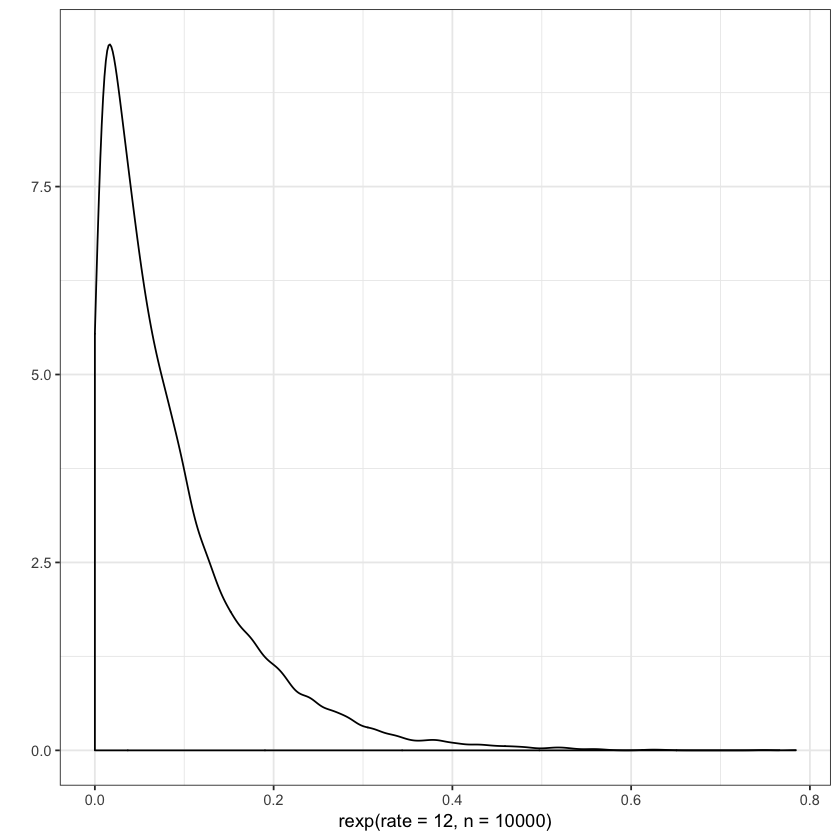

In [157]:
qplot(rexp(rate = 12, n = 1e4), geom = "density")



In [159]:
# specify files and model options
genus <-"Bilophila_et_rel"
time_cc <- bf(Bilophila_et_rel ~ 1 + time*childcarecenter + (1|subject), sigma ~ 1 + time*childcarecenter + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/t/{genus}_time-cc")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

/Users/henrikeckermann/workspace/research_master/major_research_project/orl_major_project/models/distributional/t/Bilophila_et_rel_time-cc


In [160]:
dt_time_cc <- 
    brm(
        family = student(), data = df, formula = time_cc,
        chains = 4, iter = 5000, warmup = 2000,
        file = model_file, control = control, prior = c(
            set_prior("normal(0, 1)", class = "b"),
            set_prior("exponential(6)", class = "sd"),
            set_prior("normal(0, 5)", class = "Intercept"), 
            set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
            set_prior("exponential(6)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
        )
)

Compiling the C++ model
Start sampling
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [161]:
summary(dt_time_cc)

 Family: student 
  Links: mu = identity; sigma = log; nu = identity 
Formula: Bilophila_et_rel ~ 1 + time * childcarecenter + (1 | subject) 
         sigma ~ 1 + time * childcarecenter + (1 | subject)
   Data: df (Number of observations: 174) 
Samples: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup samples = 12000

Group-Level Effects: 
~subject (Number of levels: 89) 
                    Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)           0.03      0.01     0.01     0.04        401 1.00
sd(sigma_Intercept)     0.76      0.17     0.43     1.08       1356 1.00

Population-Level Effects: 
                                  Estimate Est.Error l-95% CI u-95% CI
Intercept                             2.04      0.01     2.03     2.06
sigma_Intercept                      -3.78      0.24    -4.27    -3.32
time105                              -0.01      0.00    -0.02     0.00
childcarecenternoCC                   0.00      0.01    -0

In [ ]:
# specify files and model options
genus <-"Bilophila_et_rel"
full <- bf(Bilophila_et_rel ~ 1 + time*childcarecenter + feedings_type + (1|subject), sigma ~ 1 + time*childcarecenter + feeding_type + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/t/{genus}_full")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

In [ ]:
dt_full <- 
    brm(
        family = student(), data = df, formula = time_cc,
        chains = 4, iter = 5000, warmup = 2000,
        file = model_file, control = control, prior = c(
            set_prior("normal(0, 1)", class = "b"),
            set_prior("exponential(6)", class = "sd"),
            set_prior("normal(0, 5)", class = "Intercept"), 
            set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
            set_prior("exponential(6)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
        )
)

In [ ]:
summary(dt_time_cc)

In [ ]:
dt_time_cc %>%
    spread_draws(
        energy__, 
        lp__, 
        sd_subject__Intercept, 
        sd_subject__sigma_Intercept, 
        b_childcarecenternoCC, 
        b_time105) %>%
    select(-.chain, -.iteration, -.draw) %>%
    GGally::ggpairs()

In [ ]:
qplot(rexp(1e4, rate = 6), geom = "density")

### Predictor Feeding Mode

In [ ]:
# specify files and model options
genus <-"Bilophila_et_rel"
feeding <- bf(Bilophila_et_rel ~ 1 + feeding_type + (1|subject), sigma ~ 1 + feeding_type + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/t/{genus}_feeding_nc_default")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

In [ ]:
dt_feeding <- 
    brm(
        family = student(), data = df, formula = feeding,
        chains = 4, iter = 5000, warmup = 2000,
        file = model_file
)

In [ ]:
tidy(dt_feeding) %>% mutate_if(is.numeric, funs(round(., 2)))
t_feeding_cv10 <- kfold(dt_feeding)

### Predictor Age Weeks

In [ ]:
# specify files and model options
genus <-"Bilophila_et_rel"
age <- bf(Bilophila_et_rel ~ 1 + age_weeks.s + (1|subject), sigma ~ 1 + age_weeks.s + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/t/{genus}_age_nc_default")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

In [ ]:
dt_age <- 
    brm(
        family = student(), data = df, formula = age,
        chains = 4, iter = 5000, warmup = 2000,
        file = model_file
)

In [ ]:
summary(dt_age)
t_age_cv10 <- kfold(dt_age)

### Predictor childcarecenter

In [ ]:
# specify files and model options
genus <-"Bilophila_et_rel"
cc <- bf(Bilophila_et_rel ~ 1 + childcarecenter + (1|subject), sigma ~ 1 + childcarecenter + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/t/{genus}_cc_nc_default")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

In [ ]:
dt_cc <- 
    brm(
        family = student(), data = df, formula = cc,
        chains = 4, iter = 5000, warmup = 2000,
        file = model_file
)

In [ ]:
t_cc_cv10 <- kfold(dt_cc)

## Predictor time and feedingmode

In [ ]:
# specify files and model options
genus <-"Bilophila_et_rel"
time_feeding <- bf(Bilophila_et_rel ~ 1 + time*feeding_type + (1|subject), sigma ~ 1 + time*feeding_type + (1|subject)) 
# give individual model name for storage
file <- here("models")
model_file <- glue("{file}/distributional/t/{genus}_time-feeding")
print(model_file)
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

In [ ]:
dt_time_feeding <- 
    brm(
        family = student(), data = df, formula = time_feeding,
        chains = 4, iter = 5000, warmup = 2000, control = control,
        file = model_file, prior = c(
            set_prior("normal(0, 1)", class = "b"),
            set_prior("exponential(6)", class = "sd"),
            set_prior("normal(0, 5)", class = "Intercept"), 
            set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
            set_prior("exponential(6)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
        )
)

In [ ]:
lpd_point <- cbind(
    t_base_cv10$pointwise[, "elpd_kfold"],
    t_cc_cv10$pointwise[, "elpd_kfold"],
    t_time_cv10$pointwise[, "elpd_kfold"],
    t_feeding_cv10$pointwise[, "elpd_kfold"],
    t_age_cv10$pointwise[, "elpd_kfold"]
)
stacking_wts <- stacking_weights(lpd_point)
stacking_wts

# Bifidobacterium

I got stock for Bilophila and could not model the interaction for now. Will now try this for Bifidobacterium

In [23]:
summary(lm(Enterococcus ~ age_weeks.s, data = data))
summary(lm(Enterococcus ~ mean_age, data = data))


Call:
lm(formula = Enterococcus ~ age_weeks.s, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8950 -0.5999 -0.2123  0.4368  1.7950 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.298809   0.053641  61.498   <2e-16 ***
age_weeks.s 0.003967   0.020226   0.196    0.845    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7076 on 172 degrees of freedom
Multiple R-squared:  0.0002236,	Adjusted R-squared:  -0.005589 
F-statistic: 0.03847 on 1 and 172 DF,  p-value: 0.8447



Call:
lm(formula = Enterococcus ~ mean_age, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9239 -0.5919 -0.2251  0.4873  1.7502 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.29881    0.05360  61.550   <2e-16 ***
mean_age    -0.01728    0.03015  -0.573    0.567    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.707 on 172 degrees of freedom
Multiple R-squared:  0.001906,	Adjusted R-squared:  -0.003897 
F-statistic: 0.3284 on 1 and 172 DF,  p-value: 0.5673


In [19]:
data <- df
mean_age <- data %>% group_by(subject) %>% summarise(mean_age = mean(age_weeks.s))
data <- left_join(data, mean_age, by = "subject")